## **Download Packages**

In [1]:
!pip install patchify

## **Loading Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf
from tensorflow.keras.layers import Layer, Multiply,GlobalAveragePooling1D,MultiHeadAttention,Embedding,Lambda,Dense,Flatten,Conv2D,Dropout, Conv2DTranspose, MaxPooling2D, Input, Activation, Concatenate, UpSampling2D, Resizing,Reshape,Add,LayerNormalization,BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from tensorflow.keras.saving import register_keras_serializable
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.colors as colors
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
#from patchify import patchify
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from math import log2

## **Load Data**

In [2]:
path = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset'

In [3]:
data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 6000, shuffle = False)

Found 5682 files belonging to 2 classes.


In [4]:
for images, masks in data:
    X = images.numpy().astype("uint8")
    y = masks.numpy().astype("uint8")

print(X.shape, y.shape)

(5682, 128, 128, 3) (5682,)


In [5]:
images = X[y == 0]
masks = X[y == 1]

print(images.shape, masks.shape)

(2841, 128, 128, 3) (2841, 128, 128, 3)


In [ ]:
for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(images[i])

    plt.subplot(1, 2, 2)
    plt.imshow(masks[i])

    plt.tight_layout()
    plt.show()

## **Split Data into Train and Test**

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(images, masks, test_size = 0.2, random_state = 3)

print(X_train.shape, X_test.shape)

(2272, 128, 128, 3) (569, 128, 128, 3)


## **Mask to single Channel**

In [7]:
# Convert masks to single channel (binary)
y_train = (y_train[..., 0] > 0).astype("uint8")  # Assuming the first channel represents the mask
y_test = (y_test[..., 0] > 0).astype("uint8")

# Reshape your target arrays to match the model's output shape
y_train = y_train.reshape((-1, 128, 128, 1))
y_test = y_test.reshape((-1, 128, 128, 1))

print(y_train.shape, y_test.shape)

(2272, 128, 128, 1) (569, 128, 128, 1)


## **Function to plot metrics**

In [134]:
def plot_training_history(history, title):
    # Check if `history` is a dictionary and adapt
    if isinstance(history, dict):
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt


## **Early Stopping**

In [8]:
# Early Stopping
c1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)

## **Calculate IOU**

In [135]:
def calculate_IOU(y_true, y_pred, threshold = 0.5):
    y_pred = (y_pred > threshold).astype(np.uint8) # Binarize predictions
    intersection = np.sum(y_true * y_pred, axis = (1,2)) # Per image
    union = np.sum(y_true + y_pred, axis = (1,2)) - intersection # Per image
    iou = np.mean(intersection / (union + 1e-6)) # Avoid division by zero
    return iou

def Training_IoU(model, X_train, y_train):
    train_predictions = model.predict(X_train)
    train_predictions = train_predictions.squeeze()  # Shape:(height, width)
    y_train = y_train.squeeze()  # Shape:, height, width)

    train_iou = calculate_IOU(y_train, train_predictions)
    return train_iou

def Testing_IoU (model, X_test, y_test):
    test_predictions = model.predict(X_test)
    test_predictions = test_predictions.squeeze()  # Shape: ( height, width)
    y_test = y_test.squeeze()  # Shape: (batch_size, height, width)

    test_iou = calculate_IOU(y_test, test_predictions)
    return test_iou
    
    

## **Training history**
**IOU**

**Training and Validation Accuracy**

**Training and Validation Loss**

In [136]:
def trained_history(path, trained_model, algo, X_train, y_train, X_test, y_test):
  with open(path,'rb') as file:
    loaded_history = pickle.load(file)
  train_accuracy = loaded_history['accuracy']
  train_loss = loaded_history['loss']

  val_accuracy = loaded_history['val_accuracy']
  val_loss = loaded_history['val_loss']

  data = {
    'Algorithm': [algo[0], algo[1]],
    'Accuracy': [train_accuracy[-1], val_accuracy[-1]],
    'Loss': [train_loss[-1], val_loss[-1]],
    'IOU': [Training_IoU(trained_model,X_train, y_train), Testing_IoU(trained_model,X_test, y_test)]
  }

  df = pd.DataFrame(data)

  return df

## **Plot trained images**

In [137]:
def plot_images(X_test, y_test, unet_masks, unet_attention, selected_indices):
  #cmap = colors.ListedColormap(['gray', 'yellow'])  # Example colors

  for i in selected_indices:
    # Create a figure with 6 subplots
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 6, 1)
    plt.imshow(X_test[i].squeeze())
    plt.title(f"Original Image (Index {i})")
    plt.axis('off')

    # True mask
    plt.subplot(1, 6, 2)
    plt.imshow(y_test[i].squeeze(), cmap='viridis')
    plt.title(f'True Mask (Index {i})')
    plt.axis('off')

    # Predicted mask - U-Net
    plt.subplot(1, 6, 3)
    plt.imshow(unet_masks[i].squeeze(), cmap='viridis') # 'viridis', 'plasma', 'magma'
    plt.title(f'U-Net Mask  ')
    plt.axis('off')

    # Predicted mask - U-Net
    plt.subplot(1, 6, 4)
    plt.imshow(unet_attention[i].squeeze(), cmap='viridis') # 'viridis', 'plasma', 'magma'
    plt.title(f'U-Net Attention Mask')
    plt.axis('off')

  plt.show()

# **UNET**

### **Encoder and Decoder**

In [15]:
def encoder_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2)(x)
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(inputs)
    skip_features = tf.keras.layers.Resizing(x.shape[1], x.shape[2])(skip_features)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

### **Model Architecture**

In [ ]:
def unet_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape = input_shape)

    s1 = encoder_block(inputs, 32)
    s2 = encoder_block(s1, 64)
    s3 = encoder_block(s2, 128)
    s4 = encoder_block(s3, 256)
    print(s4.shape)
    b1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), padding = "same")(s4) # kernel_initializer = "he_uniform"
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), padding = "same")(b1) #  kernel_initializer = "he_uniform"
    b1 = tf.keras.layers.Activation('relu')(b1)

    s5 = decoder_block(b1, s4, 256)
    s6 = decoder_block(s5, s3, 128)
    s7 = decoder_block(s6, s2, 64)
    s8 = decoder_block(s7, s1, 32)

    outputs = tf.keras.layers.Conv2D(filters = num_classes, kernel_size = (3, 3), padding = "same", activation = "sigmoid")(s8)

    model = tf.keras.models.Model(inputs = [inputs], outputs = [outputs], name = 'U-Net')
    return model

In [ ]:
model = unet_model(input_shape = (128, 128, 3), num_classes = 1)
model.summary()

In [71]:
unet_trained_model = load_model("/kaggle/input/unet/tensorflow2/default/1/UNET.keras")

In [72]:
with open('/kaggle/input/unet/tensorflow2/default/1/training_history.pkl', 'rb') as file:
    history = pickle.load(file)

In [ ]:
plot_training_history(history, "UNet")

In [73]:
unet_trained_history = trained_history('/kaggle/input/unet/tensorflow2/default/1/training_history.pkl',unet_trained_model, ['U-Net (Training)', 'U-Net (Validation)'], X_train, y_train, X_test, y_test)
print(unet_trained_history)

71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step
            Algorithm  Accuracy      Loss       IOU
0    U-Net (Training)  0.859886  0.329369  0.662200
1  U-Net (Validation)  0.848209  0.359503  0.626757


In [74]:
unet_masks = unet_trained_model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


# **UNET Attention**

### **Convolution Block helper function**

In [ ]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer="he_uniform")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer="he_uniform")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

### **Encoder**

In [ ]:
def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

### **Attention Block**

In [ ]:
def attention_block(g, x, num_filters):
  shape_g = K.int_shape(g)
  shape_x = K.int_shape(x)

  Wg = Conv2D(num_filters, (1, 1), strides=1, padding='same')(g)
  Wg = BatchNormalization()(Wg)

  Wx = Conv2D(num_filters, (1, 1), strides=2, padding='same')(x)
  Wx = BatchNormalization()(Wx)

  concat_xg = Add()([Wg, Wx])
  # relu_act_xg = Activation('relu')(Wg + Wx)
  relu_act_xg = Activation('relu')(concat_xg)
  psi = Conv2D(1, (1, 1), padding='same')(relu_act_xg)
  sig_act_xg = Activation('sigmoid')(psi)
  shape_sig = K.int_shape(sig_act_xg)

  upsample = UpSampling2D(size = (shape_x[1] // shape_sig[1], shape_x[2] // shape_sig[2]))(sig_act_xg)
  out = Multiply()([upsample, x])

  return out


### **Decoder**

In [ ]:
# Here g is the decoder output or previous layer and x is the skip connection which conv output of encode before max pooling
def decoder(g, x, num_filters):
  x = attention_block(g, x, num_filters)
  #g = UpSampling2D(interpolation="bilinear")(g)
  g = Conv2DTranspose(num_filters, kernel_size=(2, 2), strides=2, padding='same')(g)
  g = Concatenate()([g, x])
  g = conv_block(g, num_filters)
  return g

### **Model Architecture**

In [ ]:
def attention_unet(input_shape, num_classes):
    inputs = Input(shape=input_shape) 

    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p3 = encoder_block(p3, 256)

    # Bottleneck
    b1 = conv_block(p3, 512)

    # Decoder
    d1 = decoder(b1, s4, 256)
    d2 = decoder(d1, s3, 128)
    d3 = decoder(d2, s2, 64)
    d4 = decoder(d3, s1, 32)
    
    output = Conv2D(num_classes, (1, 1), activation='sigmoid')(d4)

    model = Model(inputs, output, name='Attention_U-Net')
    return model

In [ ]:
unet_att = attention_unet(input_shape = (128, 128, 3), num_classes = 1)
unet_att.summary()

In [ ]:
unet_att.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss = keras.losses.BinaryCrossentropy(), 
    metrics = ["accuracy"]
)

In [117]:
def lr_scheduler(monitor, factor, patience, min_lr):
    lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=monitor, factor=factor, patience=patience, min_lr=min_lr, verbose=1
    )
    return lr

In [ ]:
unet_att_history = unet_att.fit(X_train, y_train,  epochs=100, validation_data=(X_test, y_test), batch_size=12, callbacks = [lr_scheduler, c1])

In [ ]:
with open('/kaggle/input/unet-attention/tensorflow2/default/1/training_unet_att_history.pkl', 'rb') as file:
    unet_att_history = pickle.load(file)

In [ ]:
plot_training_history(unet_att_history, "UNet Attention")

In [ ]:
#unet_att.save("unet_att.keras")

In [ ]:
#with open('/kaggle/working/training_unet_att_history.pkl', 'wb') as file:
 #   pickle.dump(unet_att_history.history, file)

In [ ]:
#!mv unet_att.keras /kaggle/working/

In [68]:
unet_att_trained_model = load_model("/kaggle/input/unet-attention/tensorflow2/default/1/unet_att.keras")

In [69]:
unet_att_trained_history = trained_history('/kaggle/input/unet-attention/tensorflow2/default/1/training_unet_att_history.pkl',unet_att_trained_model, ['U-Net Attention (Training)', 'U-Net Attention (Validation)'], X_train, y_train, X_test, y_test)
print(unet_att_trained_history)

71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step
                      Algorithm  Accuracy      Loss       IOU
0    U-Net Attention (Training)  0.914932  0.205448  0.747117
1  U-Net Attention (Validation)  0.871487  0.314036  0.677502


In [70]:
#unet_att_masks = unet_att.predict(X_test)
unet_att_masks = unet_att_trained_model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [ ]:
plot_images(X_test, y_test, unet_masks, unet_att_masks,  selected_indices = [1, 4, 22, 25, 46, 95]) # 31

# **ViT**

## **Hyperparameter**

In [12]:
# Hyperparameters
config = {}

config["image_size"] = 128
config["num_channels"] = 3
config["patch_size"] = 16
config["num_patches"] = (config["image_size"]**2) // (config["patch_size"]**2) # 128x128/16x16 = 64
config["flat_patches_shape"] = (config["num_patches"], config["patch_size"],config["patch_size"],config["num_channels"]) # 113 x 113 x 113 x 3
config["input_shape"] = (config["num_patches"], config["patch_size"]*config["patch_size"]*config["num_channels"]) # 113 patches, 768 elements each
config["classes"] = ["water","no water" ]

config["num_layers"] = 8
config["hidden_dim"] = 768
config["mlp_dim"] = 3072
config["num_heads"] = 4
config["dropout_rate"] = 0.1

In [13]:
patch_shape = (config["patch_size"], config["patch_size"], config["num_channels"])
patch_shape

(16, 16, 3)

## **Patch Function**

In [14]:
def create_patches(images, patch_size):
    # Calculate the number of patches along each dimension (e.g., 224x224 with 7x7 gives 32x32 patches)
    num_patches_per_dim = images.shape[1] // patch_size  # e.g., 128 / 16 = 8
    # Reshape images to (batch_size, num_patches, patch_size*patch_size*num_channels)
    patches = images.reshape(
        images.shape[0],
        num_patches_per_dim, patch_size,
        num_patches_per_dim, patch_size,
        images.shape[3]
    )
    # Swap and reshape to (batch_size, num_patches, flat_patch_dim)
    patches = patches.transpose(0, 1, 3, 2, 4, 5).reshape(
        images.shape[0], -1, patch_size * patch_size * images.shape[3]
    )
    return patches

In [15]:
X_train_patches = create_patches(X_train, config["patch_size"])
X_test_patches = create_patches(X_test, config["patch_size"])

#X_train_patches = X_train_patches.astype('float32') / 255.0
#X_test_patches = X_test_patches.astype('float32') / 255.0

print("Train Patches shape:", X_train_patches.shape)  # Expected: (2272, 1024, 147)
print("Test Patches shape:", X_test_patches.shape)    # Expected: (569, 1024, 147)
print("")
# Get the shape of patches
print(f"Image size: {config['image_size']} X {config['image_size']}")
print(f"Patch Size: {config['patch_size']} X {config['patch_size']}")
print(f"Patchs per Image: {X_train_patches.shape[1]}")
print(f"Element per patch: {X_train_patches.shape[-1]}")  # This will just be 768

Train Patches shape: (2272, 64, 768)
Test Patches shape: (569, 64, 768)

Image size: 128 X 128
Patch Size: 16 X 16
Patchs per Image: 64
Element per patch: 768


In [16]:
assert X_train_patches.shape[1:] == config["input_shape"], "Mismatch in input shape."

## **Display Image and Patch**

In [17]:
sample_image = X_train[0]
patches = create_patches(np.expand_dims(sample_image, axis=0), config["patch_size"])[0]

(-0.5, 127.5, 127.5, -0.5)

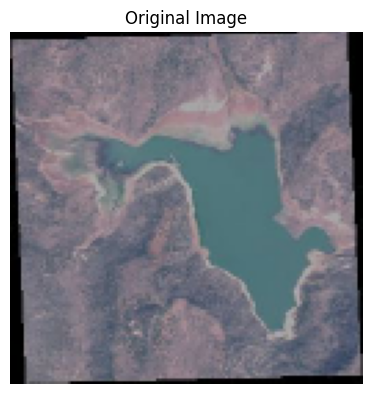

In [18]:
# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image.astype("uint8"))
plt.title("Original Image")
plt.axis("off")

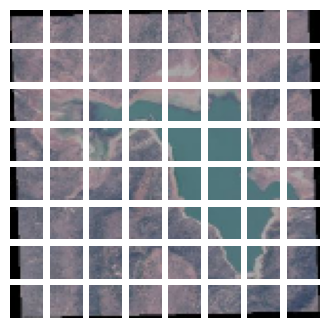

In [19]:
n = int(np.sqrt(patches.shape[0]))  # n should be the square root of the number of patches
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches):  # Iterate through the patches, not elements of a patch
    ax = plt.subplot(n, n, i + 1)
    patch_image = tf.reshape(patch, (config['patch_size'], config['patch_size'], 3))  # Reshape the entire patch
    plt.imshow(patch_image.numpy().astype('uint8'))
    plt.axis('off')

plt.show()

## **Patch and Positional Embeding**

In [20]:
def embedding(inputs, cf):
    patch_embed = Dense(cf["hidden_dim"])(inputs)
    print(f"Patch Embedding Shape: {patch_embed.shape}")
    position = tf.range(start=0, limit = cf["num_patches"], delta=1)
    pos_embed = Embedding(input_dim= cf["num_patches"], output_dim= cf["hidden_dim"])(position)

    embed = patch_embed + pos_embed
    
    return embed

## **MLP**

In [21]:
def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation = "gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)

    return x

## **Transformer Encoder**

In [22]:
def transformer_encoder(x, cf):
    skip1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(num_heads = cf["num_heads"], key_dim = cf["hidden_dim"])(x,x)
    x = Add()([x, skip1])

    skip2 = x
    x = LayerNormalization()(x)
    x = mlp(x,cf)
    x = Add()([x, skip2])

    return x

In [51]:
def decoder_block(inputs, skip_features, num_filters):
    # Upsample the input
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    # Resize the skip features to match the upsampled input
    skip_features = tf.keras.layers.Resizing(x.shape[1], x.shape[2])(skip_features)
    # Concatenate the upsampled input with the skip connection
    x = tf.keras.layers.Concatenate()([x, skip_features])
    # Apply convolutional layers
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same', kernel_initializer="he_uniform")(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same', kernel_initializer="he_uniform")(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x


In [24]:
def bottleneck(inputs, num_filters):
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), padding="same", kernel_initializer="he_uniform")(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), padding="same", kernel_initializer="he_uniform")(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [71]:
def conv_block(x, num_filters, kernel_size=3):
    x = Conv2D(num_filters, kernel_size=kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [72]:
def deconv_block(x, num_filters):
    x = Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=2)(x)
    return x

In [121]:
def unet_vit(x, skip_connections, cf):
    print(f"Input (output of transformer): {x.shape}")

    if len(skip_connections) == 4:
        z2, z4, z6, z8 = skip_connections
    else:
        raise ValueError(f"Expected 4 skip connections, but got {len(skip_connections)}.")

    # Reshape the transformer output
    patch_per_dim = int(cf["image_size"] / cf["patch_size"]) #  8 
    #z0 = Reshape((patch_per_dim, patch_per_dim, cf["hidden_dim"]))(x)
    #print(patch_per_dim)
    z0 = Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(x)
    print(f"Reshape X: {z0.shape}")

    # Bottleneck
    #b = bottleneck(z0, num_filters=512)
    #print(f"Bottleneck: {b.shape}")
    
    # Reshape skip connections
    shape = (cf["image_size"] // cf["patch_size"], 
             cf["image_size"] // cf["patch_size"], 
             cf["hidden_dim"])
    z2 = Reshape(shape)(z2)
    z4 = Reshape(shape)(z4)
    z6 = Reshape(shape)(z6)
    z8 = Reshape(shape)(z8)

    # Decoder blocks
    #s1 = decoder_block(b, z8, 256)
    #s2 = decoder_block(s1, z6, 128)
    #s3 = decoder_block(s2, z4, 64)
    #s4 = decoder_block(s3, z2, 32)

    #print(f"s1: {s1.shape}, s2:{s2.shape}, s3:{s3.shape}, s4:{s4.shape}")

    ## Decoder 1
    x = deconv_block(z8, 256)

    s = deconv_block(z6, 256)
    s = conv_block(s, 256)
    
    x = Concatenate()([x, s])

    x = conv_block(x, 256)
    x = conv_block(x, 256)

       ## Decoder 2
    x = deconv_block(x, 128)

    s = deconv_block(z4, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)

    x = Concatenate()([x, s])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

       ## Decoder 3
    x = deconv_block(x, 64)

    s = deconv_block(z2, 64)
    s = conv_block(s, 64)
    s = deconv_block(s, 64)
    s = conv_block(s, 64)
    s = deconv_block(s, 64)
    s = conv_block(s, 64)

    x = Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

     ## Decoder 4
    x = deconv_block(x, 32)

    s = conv_block(z0, 32)
    s = conv_block(s, 32)

    x = Concatenate()([x, s])
    x = conv_block(x, 32)
    x = conv_block(x, 32)

    # Output layer
    outputs = Conv2D(filters=1, kernel_size=(3, 3), padding="same", activation="sigmoid")(x)
    print(f"UNET Output {outputs.shape}")

    return outputs


In [122]:
def ViT(cf):
    input_shape = (cf["input_shape"])
    inputs = Input(input_shape)
    x = Lambda(lambda t: tf.cast(t, tf.float32))(inputs)  # Ensure inputs are float32
    x = embedding(inputs, cf)
    skip_connections = []
    for i in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)
        if i+1 in [2, 4, 6, 8]:
            skip_connections.append(x)
    outputs = unet_vit(x, skip_connections, cf)
    model = Model(inputs=inputs, outputs=outputs, name="ViT")
    return model

In [128]:
vit_model = ViT(config)

Patch Embedding Shape: (None, 64, 768)
Input (output of transformer): (None, 64, 768)
Reshape X: (None, 128, 128, 3)
UNET Output (None, 128, 128, 1)


In [129]:
vit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = "BinaryCrossentropy", metrics = ["accuracy"])

In [130]:
lr = lr_scheduler(monitor = 'val_loss', factor = 0.4, patience = 4, min_lr = 1e-5)
print(lr)

In [131]:
# Early Stopping
c1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)

In [132]:
vit_model_history = vit_model.fit(X_train_patches, y_train, validation_data=(X_test_patches, y_test), epochs=50, batch_size=16, callbacks = [lr, c1])

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 95s 216ms/step - accuracy: 0.6738 - loss: 0.6012 - val_accuracy: 0.6140 - val_loss: 1.2768 - learning_rate: 0.0010
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 25s 178ms/step - accuracy: 0.7532 - loss: 0.5095 - val_accuracy: 0.7569 - val_loss: 0.7109 - learning_rate: 0.0010
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - accuracy: 0.7655 - loss: 0.4971 - val_accuracy: 0.7261 - val_loss: 1.0924 - learning_rate: 0.0010
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.7705 - loss: 0.4862 - val_accuracy: 0.7074 - val_loss: 0.8426 - learning_rate: 0.0010
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.7801 - loss: 0.4680 - val_accuracy: 0.6000 - val_loss: 2.8176 - learning_rate: 0.0010
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.7676 - loss: 0.4870 - val_accuracy: 0.6987 - val_loss: 0.6084 - learning_rate: 0.0010
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.7

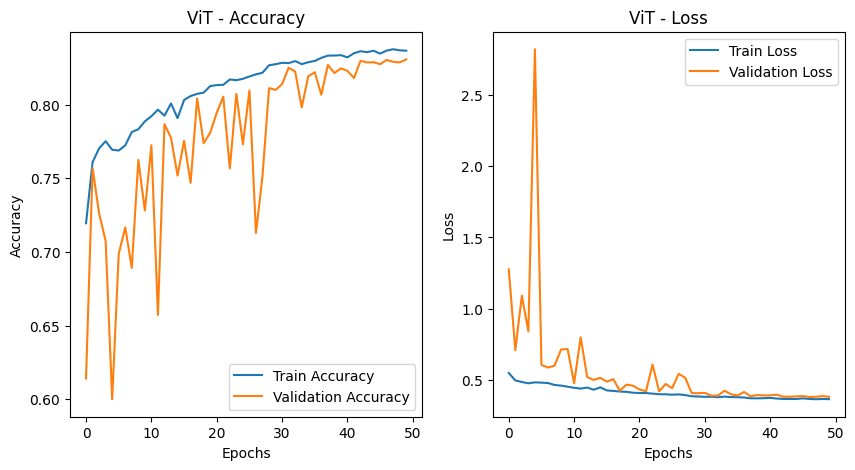

In [138]:
plot_training_history(vit_model_history, "ViT")

In [139]:
vit_model.save("vit_model.keras")

In [140]:
with open('/kaggle/working/training_vit_history.pkl', 'wb') as file:
    pickle.dump(vit_model_history.history, file)

In [141]:
vit_trained_model = load_model("/kaggle/working/vit_model.keras")

In [142]:
vit_trained_history = trained_history('/kaggle/working/training_vit_history.pkl',vit_trained_model, ['ViT - UNET (Training)', 'ViT - UNET (Validation)'], X_train_patches, y_train, X_test_patches, y_test)
print(vit_trained_history)

71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step
                 Algorithm  Accuracy      Loss       IOU
0    ViT - UNET (Training)  0.836539  0.368453  0.612961
1  ViT - UNET (Validation)  0.830639  0.385093  0.581932


In [143]:
#unet_att_masks = unet_att.predict(X_test)
vit_masks = vit_trained_model.predict(X_test_patches)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


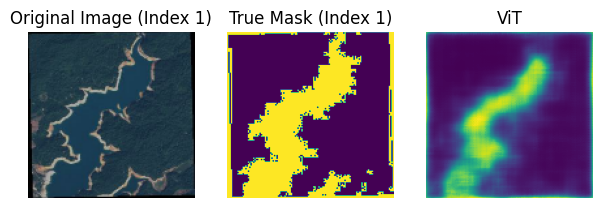

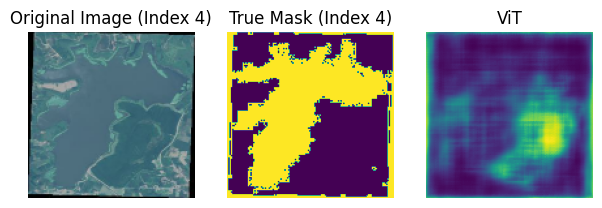

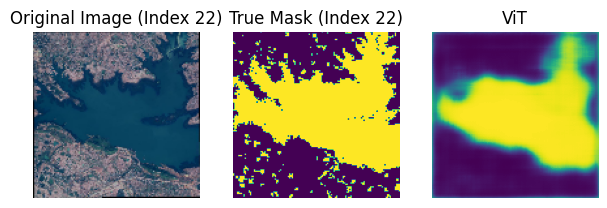

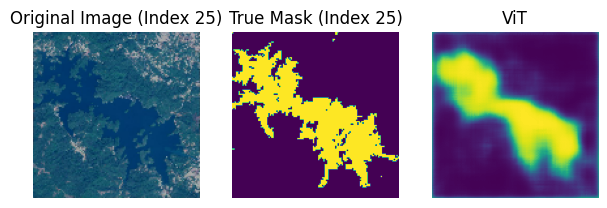

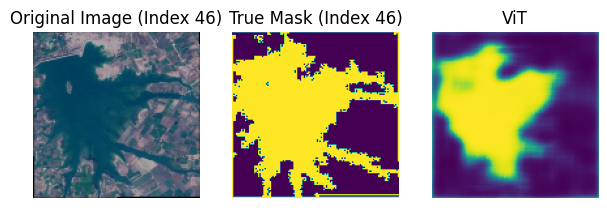

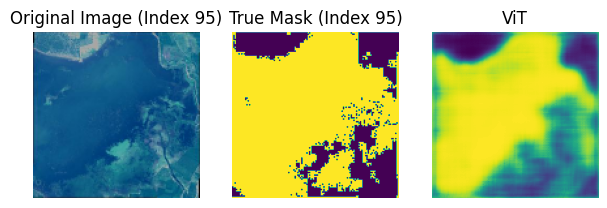

In [144]:
selected_indices = [1, 4, 22, 25, 46, 95] # 31
for i in selected_indices:
    # Create a figure with 6 subplots
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 6, 1)
    plt.imshow(X_test[i].squeeze())
    plt.title(f"Original Image (Index {i})")
    plt.axis('off')

    # True mask
    plt.subplot(1, 6, 2)
    plt.imshow(y_test[i].squeeze(), cmap='viridis')
    plt.title(f'True Mask (Index {i})')
    plt.axis('off')

    # Predicted mask - U-Net
    plt.subplot(1, 6, 3)
    plt.imshow(vit_masks[i].squeeze(), cmap='viridis') # 'viridis', 'plasma', 'magma'
    plt.title(f'ViT')
    plt.axis('off')

## **Test Sindh Data**

In [ ]:
path = '/kaggle/input/sindh-lakes'

In [ ]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=path,
    image_size=(128, 128),
    batch_size=6000,
    shuffle=False,
    label_mode=None  # Exclude labels
)

In [ ]:
for images in data:
    X = images.numpy().astype("uint8")

print(X.shape)

In [ ]:
unet_att_trained_model = load_model("/kaggle/working/unet_att.keras")

In [ ]:
unet_trained_model = load_model("/kaggle/input/unet/tensorflow2/default/1/UNET.keras")

In [ ]:
unet_att_masks = unet_att_trained_model.predict(X)
unet_masks = unet_trained_model.predict(X)

In [ ]:
for i in range(len(X)):
    plt.figure(figsize=(8,6))

    plt.subplot(1,3,1)
    plt.imshow(X[i])
    plt.title("Orignal Image")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(unet_masks[i])
    plt.title("UNET Mask")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(unet_att_masks[i])
    plt.title("UNET Attention Mask")
    plt.axis('off')

    plt.show()